# Modeling - xPressureAllowed

This notebook will work through multiple models and determine which model performs the best.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score

from xgboost import plot_importance
from matplotlib import pyplot

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv("C:/Users/19012/Documents/BDB 2023/pass_blockers.csv")
data.head()

C:\Users\19012\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (48,50) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Unnamed: 0.1,nflId,level_0,Unnamed: 0.1.1,gameId,playId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,position,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,isOnOffense,ToLeft,X_std,Y_std,back,left,right,QB,C,LEO,LT,ROLB,LG,DRT,RG,RT,LILB,RE,dist_from_ball,DLT,SCBR,REO,RILB,LE,LOLB,NLT,TE-oR,LLB,TE-iR,MLB,HB-L,NT,RLB,TE-R,NRT,TE-L,SCBiL,HB-R,SCBoL,LOLB1,DRT1,RCB,SCBiR,HB,SCBL,ROLB1,SRiWR,FB,LILB1,TE-oL,TE-iL,SRWR,LLB1,SCBoR,FB-R,FB-L,LCB,LEO1,RWR,REO1,DLT1,LOLB2,RILB1,pressure,edge,interiorDL,LB,T,G,interiorOL,num_rushers,closest_offensive_player_x,closest_offensive_player_y,second_closest_offensive_player,closest_defensive_player,second_closest_defensive_player,los_snap,dist_los_snap,O_std_1,O_std_2,Dir_std_1,Dir_std_2
0,1,177,40151.0,140,177,2021090900,97,6,2021-09-10T00:26:31.600,66.0,TB,right,42.10,24.02,0.51,1.98,0.06,48.28,308.34,ball_snap,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0,C,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,42.10,24.02,36.56,30.92,16.92,4.466453,1,5.268482,2.988043,8.796141,1.638841,1.705315,1.551838,2.885169,2.620019,3.095561,0.549181,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,1,5.0,NaN,NaN,NaN,1.705315,2.620019,41.56,-0.54,48.28,48.28,308.34,308.34
1,3,306,42377.0,245,306,2021090900,97,6,2021-09-10T00:26:31.600,76.0,TB,right,41.38,26.92,0.85,2.90,0.08,145.19,283.52,ball_snap,Pass Block,LT,NaN,NaN,NaN,0.0,0.0,1.0,0.0,42403.0,PP,0.0,T,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,41.38,26.92,36.56,30.92,16.92,4.589466,0,8.256349,0.000000,6.241354,1.383980,2.628403,4.290105,5.616494,5.494552,2.333431,3.005395,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,1,0,0,5.0,NaN,NaN,NaN,2.333431,2.628403,41.56,0.18,145.19,145.19,283.52,283.52
2,5,392,42404.0,315,392,2021090900,97,6,2021-09-10T00:26:31.600,74.0,TB,right,41.93,25.65,0.00,0.15,0.01,107.08,250.84,ball_snap,Pass Block,LG,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,PP,0.0,G,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,41.93,25.65,36.56,30.92,16.92,4.509568,0,6.897427,1.383980,7.252675,0.000000,1.495761,3.064441,4.416786,4.111070,2.042866,1.769124,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,1,1,5.0,NaN,NaN,NaN,1.495761,2.042866,41.56,-0.37,107.08,107.08,250.84,250.84
3,7,693,46163.0,560,693,2021090900,97,6,2021-09-10T00:26:31.600,65.0,TB,right,41.41,22.63,0.03,0.53,0.01,106.86,303.88,ball_snap,Pass Block,RG,NaN,NaN,NaN,0.0,0.0,1.0,0.0,53441.0,SW,0.0,G,(13:33) (Shotgun

In [4]:
players = pd.read_csv("C:/Users/19012/Documents/BDB 2023/players.csv")
players.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


In [5]:
plays = pd.read_csv("C:/Users/19012/Documents/BDB 2023/pffScoutingData.csv")
plays.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [6]:
games = pd.read_csv("C:/Users/19012/Documents/BDB 2023/games.csv")
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021091200,2021,1,09/12/2021,13:00:00,ATL,PHI
2,2021091201,2021,1,09/12/2021,13:00:00,BUF,PIT
3,2021091202,2021,1,09/12/2021,13:00:00,CAR,NYJ
4,2021091203,2021,1,09/12/2021,13:00:00,CIN,MIN


In [7]:
data = data.set_index(['gameId','nflId','playId','frameId'])

In [8]:
data.head()

Unnamed: 0  Unnamed: 0.1  level_0  \
gameId     nflId   playId frameId                                      
2021090900 40151.0 97     6                 1           177      140   
           42377.0 97     6                 3           306      245   
           42404.0 97     6                 5           392      315   
           46163.0 97     6                 7           693      560   
           52421.0 97     6                 8           779      630   

                                   Unnamed: 0.1.1                     time  \
gameId     nflId   playId frameId                                            
2021090900 40151.0 97     6                   177  2021-09-10T00:26:31.600   
           42377.0 97     6                   306  2021-09-10T00:26:31.600   
           42404.0 97     6                   392  2021-09-10T00:26:31.600   
           46163.0 97     6                   693  2021-09-10T00:26:31.600   
           52421.0 97     6                   779  2021-09-10T00:26:31.600   

                                   jerseyNumber team playDirection      x  \
gameId     nflId   playId frameId                                           
2021090900 40151.0 97     6                66.0   TB         right  42.10   
           42377.0 97     6                76.0   TB         right  41.38   
           42404.0 97     6                74.0   TB         right  41.93   
           46163.0 97     6                65.0   TB         right  41.41   
           52421.0 97     6                78.0   TB         right  41.11   

                                       y     s     a   dis       o     dir  \
gameId     nflId   playId frameId                                            
2021090900 40151.0 97     6        24.02  0.51  1.98  0.06   48.28  308.34   
           42377.0 97     6        26.92  0.85  2.90  0.08  145.19  283.52   
           42404.0 97     6        25.65  0.00  0.15  0.01  107.08  250.84   
           46163.0 97     6        22.63  0.03  0.53  0.01  106.86  303.88   
           52421.0 97     6        21.31  0.33  1.25  0.03   54.53  211.91   

                                       event    pff_role pff_positionLinedUp  \
gameId     nflId   playId frameId                                              
2021090900 40151.0 97     6        ball_snap  Pass Block                   C   
           42377.0 97     6        ball_snap  Pass Block                  LT   
           42404.0 97     6        ball_snap  Pass Block                  LG   
           46163.0 97     6        ball_snap  Pass Block                  RG   
           52421.0 97     6        ball_snap  Pass Block                  RT   

                                   pff_hit  pff_hurry  pff_sack  \
gameId     nflId   playId frameId                                 
2021090900 40151.0 97     6            NaN        NaN       NaN   
           42377.0 97     6            NaN        NaN       NaN   
           42404.0 97     6            NaN        NaN       NaN   
           46163.0 97     6            NaN        NaN       NaN   
           52421.0 97     6            NaN        NaN       NaN   

                                   pff_beatenByDefender  pff_hitAllowed  \
gameId     nflId   playId frameId                                         
2021090900 40151.0 97     6                         0.0             0.0   
           42377.0 97     6                         0.0             0.0   
           42404.0 97     6                         0.0             0.0   
           46163.0 97     6                         0.0             0.0   
           52421.0 97     6                         0.0             0.0   

                                   pff_hurryAllowed  pff_sackAllowed  \
gameId     nflId   playId frameId                                      
2021090900 40151.0 97     6                     0.0              0.0   
           42377.0 97     6                     1.0              0.0   
           42404.0 97     6                     0.0

## Train/Test Split

In [75]:
features = ['s', 'a', 'dis', 'down', 'yardsToGo', 'defendersInBox', 'pff_playAction', 'X_std', 'Y_std', 'QB', 'num_rushers', 'closest_defensive_player', 'second_closest_defensive_player', 'dist_los_snap', 'O_std_2', 'Dir_std_2', 'edge', 'interiorOL', 'T', 'G']
label = 'pressure_allowed'

X = data[features]
y = data[label]

KeyError: "['closest_offensive_player'] not in index"

In [45]:
X.head()

s     a   dis  down  yardsToGo  \
gameId     nflId   playId frameId                                      
2021090900 41263.0 97     6        0.96  0.90  0.11     3          2   
           42403.0 97     6        0.37  2.44  0.06     3          2   
           44955.0 97     6        0.56  2.42  0.06     3          2   
           53441.0 97     6        0.36  2.85  0.02     3          2   
           53504.0 97     6        0.03  0.18  0.01     3          2   

                                   defendersInBox  pff_playAction  X_std  \
gameId     nflId   playId frameId                                          
2021090900 41263.0 97     6                   6.0               0  43.30   
           42403.0 97     6                   6.0               0  43.90   
           44955.0 97     6                   6.0               0  43.35   
           53441.0 97     6                   6.0               0  43.68   
           53504.0 97     6                   6.0               0  43.70   

                                   Y_std         QB  num_rushers  \
gameId     nflId   playId frameId                                  
2021090900 41263.0 97     6        18.89   7.802083          5.0   
           42403.0 97     6        32.63  10.452009          5.0   
           44955.0 97     6        25.18   5.783641          5.0   
           53441.0 97     6        21.93   6.473832          5.0   
           53504.0 97     6        26.67   6.521633          5.0   

                                   closest_offensive_player  dist_los_snap  \
gameId     nflId   playId frameId                                            
2021090900 41263.0 97     6                        3.263817          -1.74   
           42403.0 97     6                        6.000000          -2.34   
           44955.0 97     6                        1.495761          -1.79   
           53441.0 97     6                        2.375479          -2.12   
           53504.0 97     6                        2.042866          -2.14   

                                   O_std_2  Dir_std_2  edge  interiorDL  LB  
gameId     nflId   playId frameId                                            
2021090900 41263.0 97     6         316.48     288.76     1           0   0  
           42403.0 97     6         278.77     247.75     0           0   1  
           44955.0 97     6         243.27     288.42     0           1   0  
           53441.0 97     6         277.16     316.78     0           0   1  
           53504.0 97     6          31.86     345.84     1           0   0

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# sanity check
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train.shape[0]/data.shape[0])

(109897, 138)
(87917, 18)
(87917,)
0.7999945403423205


## Outcome Distribution

The first step I'll take is to observe the distribution of the label (pressure). If there is a class imbalance, then I will use SMOTE to balance the classes. Otherwise, I will leave the label alone.

In [48]:
print('Rows in class 0:',data['pressure'].value_counts()[0]/(data['pressure'].value_counts()[0]+data['pressure'].value_counts()[1]))

Rows in class 0: 0.8749101431340255


The data is imbalanced; therefore, I will use SMOTE to resolve this issue.

In [49]:
X_train.head()

,,,,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,QB,num_rushers,closest_offensive_player,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB
gameId,nflId,playId,frameId,,,,,,,,,,,,,,,,,,
2021091300,44859.0,3712,21,5.04,1.01,0.50,1,10,5.0,0,58.98,34.690000,5.613840,5.0,1.002846,-1.55,195.70,268.47,0,0,1
2021091202,46230.0,1774,9,1.12,1.61,0.12,2,10,7.0,0,37.82,24.813333,7.612838,4.0,4.206293,48.20,92.61,128.14,0,0,1
2021091209,44847.0,1247,22,2.24,2.11,0.23,1,10,7.0,1,85.13,31.360000,3.395541,4.0,1.051190,-0.62,315.73,267.43,0,1,0
2021091200,42497.0,1558,21,2.66,1.54,0.28,2,4,6.0,0,33.91,26.070000,5.919975,4.0,2.026746,-0.61,235.68,306.88,0,1,0
2021091202,41341.0,1319,13,1.30,0.59,0.14,2,10,7.0,0,60.74,24.563333,5.063596,4.0,1.598405,-0.21,421.59,444.31,0,1,0


In [50]:
#################### need to fix this ##############################
X_train['dist_los_snap'] = X_train['dist_los_snap'].fillna(-1)

In [51]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [52]:
print(X_train.shape)
print(X_res.shape)
print(y_res.shape)

(87917, 18)
(153948, 18)
(153948,)


## Create Model

Begin with a naive model that predicts the majority class in the former dataset. This model will be used as the baseline. Then, I will begin to increase the complexity of the models used by first running a logistic regression model, followed by xgboost. The best performing model will be used to create probabilities on the dataset.

In [53]:
# naive model
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="constant",constant=1)
dummy_clf.fit(X_res, y_res)
y_pred = dummy_clf.predict(X_test)
f1_score(y_test, y_pred)

0.2262750161394448

In [54]:
X_test['dist_los_snap'] = X_test['dist_los_snap'].fillna(-1)

In [55]:
# logistic regression
clf = LogisticRegression(random_state=0,max_iter=100000000).fit(X_res, y_res)
# clf.predict(X[:2, :])
# clf.predict_proba(X[:2, :])
# clf.score(X_test, y_test)

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred)

0.3510664378524148

Increasing the model complexity while keeping the model simple improved the score by 15%. That's exciting to see especially when I plan to use a more complex model.

In [56]:
# xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_res, y_res)

y_pred = xgb_model.predict(X_test)

In [57]:
f1_score(y_test, y_pred)

0.8135269392434085

The xgboost outperforms the other models immensely; therefore, I will use the xgboost model to generate pressure probabilities for each pass rusher. First, I will calculate the probability at the frame-level. Then, I will take the average pressure probability.

In [58]:
#Predicting probabilities
prob_val = xgb_model.predict_proba(X_test)[:, 1]

In [59]:
X_test['xPress'] = prob_val
X_test.head()

,,,,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,QB,num_rushers,closest_offensive_player,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB,xPress
gameId,nflId,playId,frameId,,,,,,,,,,,,,,,,,,,
2021090900,46132.0,4141,15,4.33,5.33,0.41,3,1,6.0,0,28.53,36.173333,8.486000,4.0,4.195092,61.68,430.26,423.62,0,0,0,0.012217
2021091204,40171.0,4401,7,0.11,0.84,0.05,3,13,8.0,1,65.20,27.440000,3.608490,4.0,1.994242,-1.00,281.47,357.93,1,0,0,0.472748
2021091300,40042.0,3098,7,0.51,2.03,0.05,1,10,8.0,1,51.36,29.980000,5.250038,5.0,2.170921,-0.63,258.12,237.63,0,1,0,0.102252
2021090900,42560.0,3261,23,1.48,1.88,0.16,1,10,6.0,0,55.11,28.210000,4.141075,5.0,1.135650,-1.68,280.99,249.22,0,1,0,0.049689
2021091207,52416.0,2553,9,1.84,3.35,0.17,1,10,7.0,0,97.69,23.003333,8.647416,5.0,4.242134,-74.58,155.44,110.46,0,0,1,0.061975


In [60]:
print(X_test.shape)
print(y_test.shape)

(21980, 19)
(21980,)


In [61]:
final_df = X_test.reset_index()
final_df.head()

,gameId,nflId,playId,frameId,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,QB,num_rushers,closest_offensive_player,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB,xPress
0,2021090900,46132.0,4141,15,4.33,5.33,0.41,3,1,6.0,0,28.53,36.173333,8.486000,4.0,4.195092,61.68,430.26,423.62,0,0,0,0.012217
1,2021091204,40171.0,4401,7,0.11,0.84,0.05,3,13,8.0,1,65.20,27.440000,3.608490,4.0,1.994242,-1.00,281.47,357.93,1,0,0,0.472748
2,2021091300,40042.0,3098,7,0.51,2.03,0.05,1,10,8.0,1,51.36,29.980000,5.250038,5.0,2.170921,-0.63,258.12,237.63,0,1,0,0.102252
3,2021090900,42560.0,3261,23,1.48,1.88,0.16,1,10,6.0,0,55.11,28.210000,4.141075,5.0,1.135650,-1.68,280.99,249.22,0,1,0,0.049689
4,2021091207,52416.0,2553,9,1.84,3.35,0.17,1,10,7.0,0,97.69,23.003333,8.647416,5.0,4.242134,-74.58,155.44,110.46,0,0,1,0.061975


In [62]:
pressures = pd.DataFrame(y_test).reset_index()
final_df['pressure'] = pressures[['pressure']]
final_df.head()

,gameId,nflId,playId,frameId,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,QB,num_rushers,closest_offensive_player,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB,xPress,pressure
0,2021090900,46132.0,4141,15,4.33,5.33,0.41,3,1,6.0,0,28.53,36.173333,8.486000,4.0,4.195092,61.68,430.26,423.62,0,0,0,0.012217,0
1,2021091204,40171.0,4401,7,0.11,0.84,0.05,3,13,8.0,1,65.20,27.440000,3.608490,4.0,1.994242,-1.00,281.47,357.93,1,0,0,0.472748,0
2,2021091300,40042.0,3098,7,0.51,2.03,0.05,1,10,8.0,1,51.36,29.980000,5.250038,5.0,2.170921,-0.63,258.12,237.63,0,1,0,0.102252,0
3,2021090900,42560.0,3261,23,1.48,1.88,0.16,1,10,6.0,0,55.11,28.210000,4.141075,5.0,1.135650,-1.68,280.99,249.22,0,1,0,0.049689,0
4,2021091207,52416.0,2553,9,1.84,3.35,0.17,1,10,7.0,0,97.69,23.003333,8.647416,5.0,4.242134,-74.58,155.44,110.46,0,0,1,0.061975,0


## Feature Importance

Let's take a look at the features which the models thinks are valuable. This will allow us to interpret the model better.

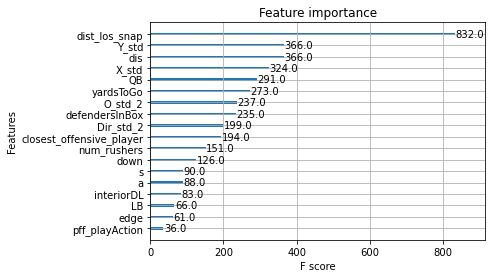

In [63]:
plot_importance(xgb_model)
pyplot.show()

It's interesting to see how important distance to the line of scrimmage at snap is considering the model is making predictions from snap to throw. At the same time, it makes sense because blitzing from 7 yards requires you to run 7 yards before getting close to someone whereas blitzing from 1 yard puts you right into the action at the time of the snap. Yards to go is also in the top 6 most important which makes sense because a longer distance to get the first down allows the pass rushers to pin their ears back and focus on the pass with the run being removed the equation.

In [64]:
final_df.to_csv("C:/Users/19012/Documents/BDB 2023/pressure_predictions.csv")